In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord


colors  = ['#5f4b8b','#008080','#4be8f9'] 


directory = '/home/bethany/Projects/0_Data/0_SUMS_Catalogs/'
plt.style.use('/home/bethany/Projects/0_PublishedCode/SUMS_UVPhotometricCatalog/sums.mplstyle')

def Quad(X1,X2):
    return np.sqrt(X1**2+X2**2)

# Import photometry from SUMS catalog
lmc = pd.read_csv(directory+'CompleteCatalog/Step5/lmc_colors.csv')
smc = pd.read_csv(directory+'CompleteCatalog/Step5/smc_colors.csv')
# Add column to indicate what galaxy they are in 
lmc['galaxy'] = 'lmc'
smc['galaxy'] = 'smc'

# Combine together
df = pd.concat([lmc, smc])

# Drop any unnamed columns
df = df.drop([col for col in df.columns if 'Unnamed' in col], axis=1)

# Reset index
df = df.reset_index(drop=True)

# Add Discovery Name
discovery_ra = [15.24876,14.25651,14.41704,16.00199,77.20574,76.19464,82.00481,86.86671,81.58229,77.16778,77.84628,83.11642,81.8678,80.916,84.05355,83.89011,81.69701,80.48712,78.34581,84.13771,15.48006,15.84282,15.92665,12.68916,15.97596]
discovery_dec = [-72.62048,-72.60092,-71.98791,-72.27852,-69.0916,-69.04014,-69.99687,-69.1021,-69.37607,-69.18455,-69.8981,-70.30682,-68.68436,-68.61127,-69.45609,-70.31835,-68.82376,-69.42087,-69.37446,-69.44082,-72.45029,-72.10988,-72.02792,-73.26791,-72.12816]
discovery_coord = SkyCoord(discovery_ra, discovery_dec, unit='deg')
discovery_name = ['Star_1','Star_2','Star_3','Star_4','Star_5','Star_6','Star_7','Star_8','Star_9','Star_10','Star_11','Star_12','Star_13','Star_14','Star_15','Star_16','Star_17','Star_18','Star_19','Star_20','Star_21','Star_22','Star_23','Star_24','Star_25']

df_co = SkyCoord(df['ra'], df['dec'], unit='deg')

for name, coordinate in zip(discovery_name, discovery_coord):
    distances = coordinate.separation(df_co).arcsecond
    min_distance = np.min(distances)
    row = df[distances == min_distance]
    # If no matching source is found, print the minimum distance and the name of the source
    if min_distance > 0.1:
        print(min_distance)
        print(name)
    # Otherwise add it to the dataframe
    else:
        df.loc[row.index,'discovery_name'] = name
df = df[~df['discovery_name'].isnull()].reset_index(drop=True)
# Sort by Star number so they are comparable when we take the difference
df['Star'] = df['discovery_name'].str.extract(r'(\d+)')
df['Star'] = df['Star'].astype(int)
df = df.sort_values(by='Star')
df = df.reset_index(drop=True)

# Import photometry from discovery paper 
cols = ['Star', 'RA', 'DEC', 'n5', 'closest', 'uvw2', 'W2-FF','uvm2', 'M2-FF', 'uvw1', 'W1-FF', 'U', 'B', 'V', 'I']
uv_filters = ['uvw2', 'uvm2', 'uvw1']
disc = pd.read_csv(directory+'Drout23/Photometry.txt', delimiter='\&', names=cols, engine='python',comment='#',header=None)
for uvfilter in uv_filters:
    # Split col by '\t'
    col = disc[uvfilter].str.split('\t', expand=True)
    disc[uvfilter] = col[1]
    disc[f'{uvfilter}_err'] = col[3]
    # Us minus them 
    disc[f'{uvfilter}_diff']  = df[uvfilter] - disc[uvfilter].astype(float)
    # Reminder this is the combined error in both measurements
    disc[f'{uvfilter}_diff_err'] = Quad(df[f'{uvfilter}_err'], disc[f'{uvfilter}_err'].astype(float))

disc

,Star,RA,DEC,n5,closest,uvw2,W2-FF,uvm2,M2-FF,uvw1,...,I,uvw2_err,uvw2_diff,uvw2_diff_err,uvm2_err,uvm2_diff,uvm2_diff_err,uvw1_err,uvw1_diff,uvw1_diff_err
0,1,15.24876,-72.62048,0,5.33,16.18,1.00,16.26,1.00,16.40,...,\t18.22\t$\pm$\t0.05\t\\,0.05,-0.019650,0.058653,0.07,0.048078,0.076275,0.07,0.000751,0.077847
1,2,14.25651,-72.60092,1,4.00,17.94,0.92,17.98,0.91,18.05,...,\t19.63\t$\pm$\t0.07\t\\,0.09,-0.086195,0.099395,0.10,-0.041411,0.110266,0.17,-0.102121,0.181139
2,3,14.41704,-71.98791,2,3.77,17.86,0.95,18.00,0.97,18.17,...,\t19.77\t$\pm$\t0.08\t\\,0.07,-0.030120,0.076071,0.14,0.018313,0.151399,0.10,-0.045602,0.115843
3,4,16.00199,-72.27852,3,2.46,17.82,0.62,17.88,0.61,18.01,...,\t19.99\t$\pm$\t0.08\t\\,0.11,-0.070912,0.112791,0.11,-0.061533,0.115933,0.13,-0.037814,0.134986
4,5,77.20574,-69.09160,1,4.47,17.73,0.66,17.80,0.63,17.81,...,\t19.03\t$\pm$\t0.06\t\\,0.08,-0.031545,0.085184,0.11,-0.023120,0.117358,0.11,0.032417,0.116678
5,6,76.19464,-69.04014,3,3.54,17.31,0.82,17.56,0.76,17.62,...,\t19.30\t$\pm$\t0.06\t\\,0.10,0.124964,0.103146,0.10,0.024509,0.104602,0.09,0.033568,0.095117
6,7,82.00481,-69.99687,1,3.56,17.86,0.95,17.97,0.92,18.06,...,\t...\t\t\t\\,0.09,-0.017103,0.093589,0.10,-0.041256,0.107474,0.10,-0.016733,0.106170
7,8,86.86671,-69.10210,0,6.74,18.16,1.00,18.27,1.00,18.40,...,\t20.31\t$\pm$\t0.14\t\\,0.07,-0.000234,0.077248,0.09,-0.029109,0.096256,0.08,-0.014034,0.086784
8,9,81.58229,-69.37607,1,2.18,17.87,0.89,17.93,0.92,18.00,...,\t19.63\t$\pm$\t0.13\t\\,0.11,-0.005381,0.113514,0.12,0.015097,0.125320,0.08,0.042733,0.086044
9,10,77.16778,-69.18455,0,5.24,18.01,0.94,18.02,0.93,18.25,...,\t19.77\t$\pm$\t0.08\t\\,0.09,-0.008990,0.094249,0.10,-0.039635,0.106522,0.10,-0.030247,0.106510


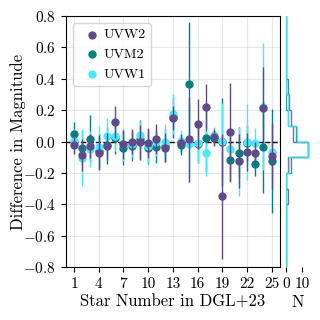

In [ ]:
from  matplotlib import rcParams
rcParams["mathtext.fontset"] = 'cm'
rcParams["axes.labelsize"] = 12
rcParams["lines.markersize"] = 5
rcParams["lines.linewidth"] = 1
rcParams["legend.fontsize"] = 10

f = plt.figure(constrained_layout=False, figsize=(3.36,3.36))
ratio = 0.9
gs = f.add_gridspec(1, 2,  width_ratios=(ratio,1-ratio))
ax = f.add_subplot(gs[0])
bx = f.add_subplot(gs[1])

# Plot scatter points
ax.errorbar(disc['Star'], disc['uvw2_diff'],yerr=disc['uvw2_diff_err'],fmt='o',c=colors[0],zorder=10)
ax.errorbar(disc['Star'], disc['uvm2_diff'],yerr=disc['uvm2_diff_err'],fmt='o',c=colors[1])
ax.errorbar(disc['Star'], disc['uvw1_diff'],yerr=disc['uvw1_diff_err'],fmt='o',c=colors[2])
# Plot some dummy points for the legend
ax.scatter(0,-1,c=colors[0],label='UVW2')
ax.scatter(0,-1,c=colors[1],label='UVM2')
ax.scatter(0,-1,c=colors[2],label='UVW1')
# Residual Line 
ax.axhline(0,c='k',ls='--')
# Labels 
#plt.xlabel(r'Star Number in Drout, G$\mathrm{\ddot{o}}$etberg, Ludwig 2023',color='black')
ax.set_xlabel('Star Number in DGL+23',color='black',labelpad=3)
ax.set_ylabel('Difference in Magnitude',color='black',labelpad=-2)
# Legend 
ax.legend(loc='upper left',handletextpad=-0.2)
# Limits
ax.set_xlim(0,26)
ydim = [-0.8,0.8]
ax.set_ylim(ydim)
ax.grid(True,alpha=0.3)
# Ticks 
ax.set_xticks(np.arange(1,26,3))
ax.set_xticklabels([str(i) for i in np.arange(1,26,3)])

# HISTOGRAM 
ybins = np.linspace(ydim[0],ydim[1],16)
binwidth = 0.1
ybins = np.arange(-0.8, 0.8 +binwidth, binwidth)
# Regular Counts 
hist, bins, _ = bx.hist(disc['uvw2_diff'],bins=ybins,color=colors[0],alpha=0.8,histtype='step',orientation='horizontal',lw=1,range=(ydim[0],ydim[1]))
hist, bins, _ = bx.hist(disc['uvm2_diff'],bins=ybins,color=colors[1],alpha=0.8,histtype='step',orientation='horizontal',lw=1,range=(ydim[0],ydim[1]))
hist, bins, _ = bx.hist(disc['uvw1_diff'],bins=ybins,color=colors[2],alpha=0.8,histtype='step',orientation='horizontal',lw=1,range=(ydim[0],ydim[1]))
bx.set_ylim(ydim)
# Turn off ylabel and axis 
bx.set_yticklabels([])
# Turn off spines 
bx.spines['left'].set_visible(False)
bx.spines['right'].set_visible(False)
bx.spines['top'].set_visible(False)
bx.spines['bottom'].set_visible(False)
bx.yaxis.set_visible(False)
bx.set_xlim(0,15)
xticks = [0,10]
bx.set_xticks(xticks)
bx.set_xticklabels([str(i) for i in xticks])
bx.set_xlabel('N',labelpad=3)

plt.tight_layout(w_pad=0.15)
plt.savefig(f'ComparisonToDiscovery.pdf',bbox_inches='tight',dpi=300)

In [ ]:
data = np.array(disc[['uvw2_diff', 'uvm2_diff', 'uvw1_diff']]).flatten()
np.median(data)

-0.014034005249634163